# Group analysis

in this module, we will cover how we go from modelling brain response in each voxel for a single participant to making inferences about the group. We will cover the following topics:

* Mixed effects model
* how to use the summary approach to make inference at second level
* how to perform many types of inferences at second level with different types of design matrices.

Preparation for this analysis: preprocessing multiple subject's data and finish the first level analysis of these participants.

## Hierarchial data structure

We can think the data as being organized into a hierarchical structure. For each brain, we are measuring BODL activity in hundreds of thousands of cubic voxels sampled at about 0.5 Hz (i.e., TR = 2s). Our experimental task will have many different trials for each ocndition (secs). and these trials may be spread across multiple scanning runs (minutes), or entire scanning sessions (hours). We are ultimatelely interested in modeling all of these different scales of data to make an inference abou the function of a particular region of the brain across the group of participants we sampled, which we would hope will generalized to the broader population.

In the past few notebooks, we have explored how to preprocess the data to reduce noise and enhance our signal and also how we can estimate responses in each voxel to specific conditions within a single participant based on convolving our experimental design with a canonical hemodyamic response function (HRF). 

Here we will discuss how we combine these brain responses estimated at the first-level in a second-level model to make inferences about the group

### First level - Single Subject Model

At the first level model, for each participant, we can define our model as:

$$ Y_{i} = X_{i}\beta + \epsilon_{i}$$

Where $i$ is an observation for a single participant and 

$$ \epsilon_{i} \sim N(0, \sigma_{i}^2)$$

Because participants are independent, it is possible to estimate each participant separately.

To provide a concrete illustration of the different sources of variability in a signal, let's make a quick simulation a hypothetical voxel timeseries.

/home/hcp4715/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


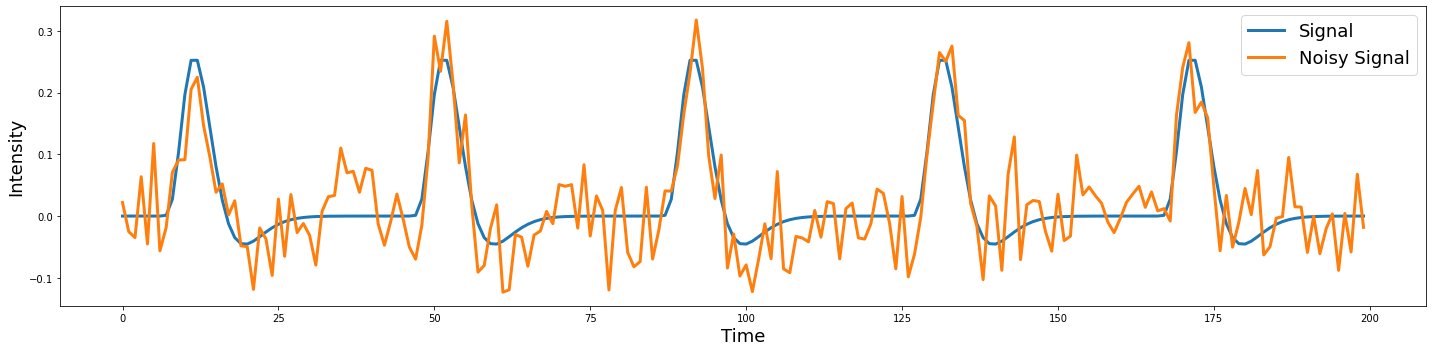

In [8]:
%matplotlib inline

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.external import glover_hrf
from scipy.stats import ttest_1samp

def plot_timeseries(data, linewidth=3, label=None, axes=True):
    f,a = plt.subplots(figsize=(20,5))
    a.plot(data, linewidth=linewidth)
    a.set_ylabel('Intensity', fontsize=18)
    a.set_xlabel('Time', fontsize=18)
    plt.tight_layout()
    
    if label is not None:
        plt.legend(label, fontsize=18)
    if not axes:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

def simulate_timeseries(n_tr=200, n_trial=5, amplitude=1, tr=1, sigma=0.5):
    y = np.zeros(n_tr)
    y[np.arange(20, n_tr, int(n_tr/n_trial))] = amplitude
    
    hrf = glover_hrf(tr, oversampling=1)
    y = np.convolve(y, hrf, mode='same')
    epsilon = sigma*np.random.randn(n_tr)
    y = y + epsilon
    
    return y

sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)

plot_timeseries(np.vstack([sim1, sim2]).T, label=['Signal', 'Noisy Signal'])

### Second level summary of between group variance

In the second level model, we are interested in relating the subject specific parameters contained in $\beta$ to the popluation parameters $\beta_{g}$. We assume that the first level parameters are randomly sampled from a population of possible regression parameters.

$$\beta = X_{g}\beta_{g} + \eta$$

$$\eta \sim N(0, \sigma_{g}^2)$$

Now, let's add noise onto the beat parameter to see what happens.

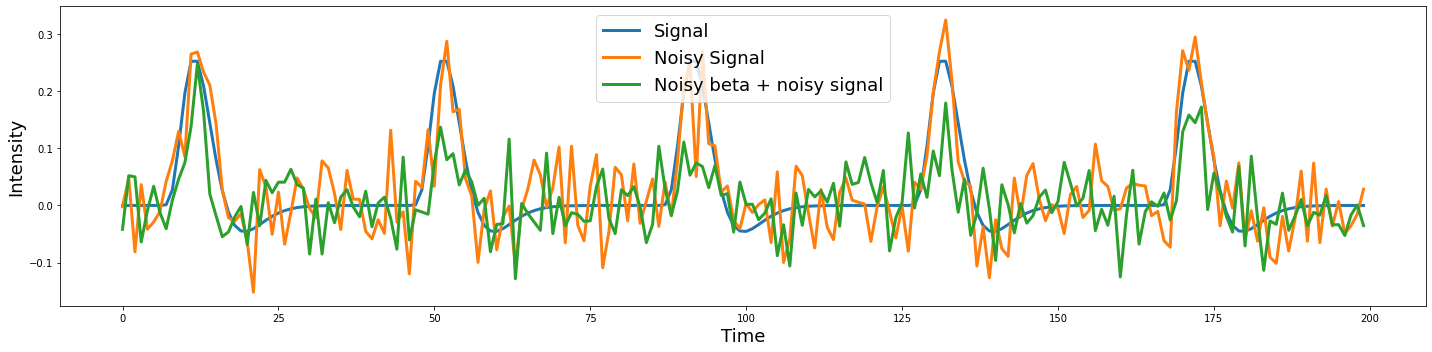

In [2]:
beta = np.abs(np.random.randn())*3
sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)
sim3 = simulate_timeseries(amplitude=beta, sigma=0.05)

plot_timeseries(np.vstack([sim1, sim2, sim3]).T, label=['Signal', 'Noisy Signal', 'Noisy beta + noisy signal'])

Try running the above code sveral times. You will see how the beta parameter impacts the amplitude of each trial, while the noise appears to be random and uncorrelated with the signal.


Let's try simulating three subjects with beta drawn from a normal distributaion

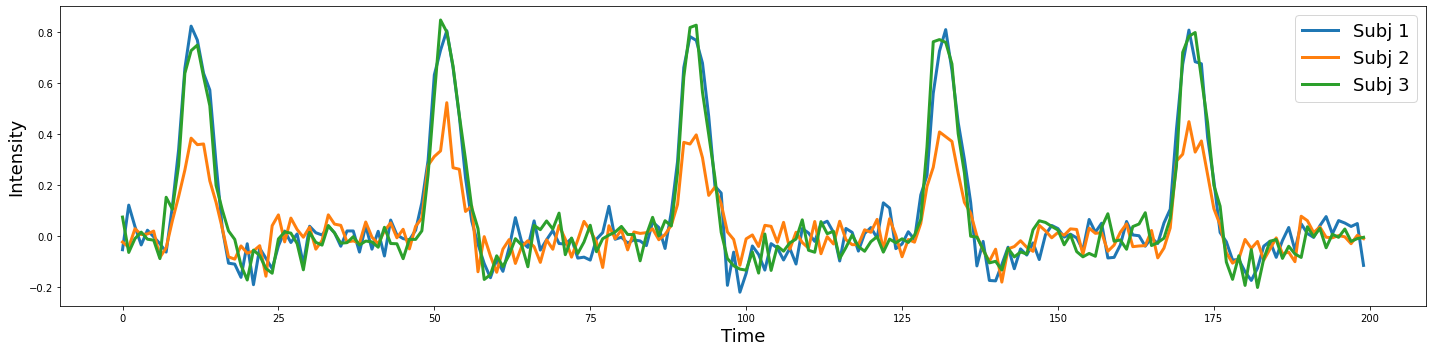

In [3]:
sim1 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim2 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim3 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)

plot_timeseries(np.vstack([sim1, sim2, sim3]).T, label=['Subj 1', 'Subj 2', 'Subj 3'])

### Mixed effect model

In neuroimaging data analysis, there are two main approaches to implementing these different models. Some software packages attempt to use a computationally efficient approximation and use what is called a two-stage summmary statistic approach. First level models are estimated separately for every participant and then the betas from each participants' model is combined in a second level model. This is the strategy implemented in SPM and is computationally efficient. However, another approach simultaneously estimates the first and second level models at the same time and often use algorithms that iterate back and forth from the single to the group. the main advantage of this approach over the two-stage approach is that the uncertainty in the parameter estimates at the first-level can be appropriately weighted at the group level. This is the approach implemented in FSL, BrainVoyager, and AFNI. 

The advantage of the true random effects simultaneous parameter esimation only probably benefits getting more reliable estimates when the sample size is small. 

A full mixed effect model can be written as,

$$Y_{i} = X_{i}(X_{g}\beta_{g} + \eta) + \epsilon_{i}$$

or 

$$ Y \sim (XX_{g}\beta_{g}, X\sigma_{g}^2X^{T} + \sigma^{2})$$

Now, let's try to recover the beta estimates from our 3 simulated subjects.

Text(0, 0.5, 'Estimated Beta')

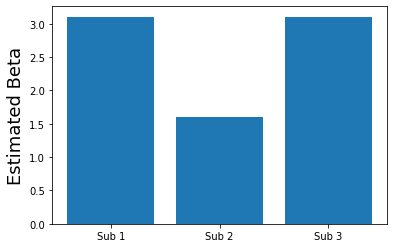

In [4]:
# create a design matrix with an intercept and predicted response
task = simulate_timeseries(amplitude=1, sigma=0)

X = np.vstack([np.ones(len(task)), task]).T

# Loop over each of the simulated participant and estimate the amplitude of the response

betas = []

for sub in [sim1, sim2, sim3]:
    beta, _, _, _, _ = regress(X, sub)
    betas.append(beta[1])
    

# plot estimated amplitude fro each participant
plt.bar(['Sub 1', 'Sub 2', 'Sub 3'], betas)
plt.ylabel('Estimated Beta', fontsize=18)

What if we simulate lots of participants? What would the distribution of betas look like?

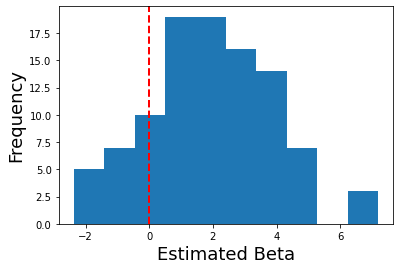

In [5]:
# create a design matrix with an intercept and predicted response

task = simulate_timeseries(amplitude=1, sigma=0)
X = np.vstack([np.ones(len(task)), task]).T

# Loop over each of the simulated participants and estimate the amplitude of the response
betas = []
for sub in range(100):
    sim = simulate_timeseries(amplitude=2+np.random.randn()*2, sigma=0.05)
    beta, _, _, _, _ = regress(X, sim)
    betas.append(beta[1])
    
# Plot distribution of estimated amplitude for each participant
plt.hist(betas)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Estimated Beta', fontsize=18)
plt.axvline(x=0, color='r', linestyle='dashed', linewidth=2)

We can test whether there is a reliable response to our experiment in a specific voxel, using an one-sample t-test.

In [6]:
ttest_1samp(betas, 0)

Ttest_1sampResult(statistic=9.962324681002979, pvalue=1.3218870069356318e-16)

Note that before this group analysis, we need to run 1st-level analysis for several participants

### One sample t-test

For our first group analysis, let's try to examine which regions of the brain are consistently activated across participants. We will just load the first regressor in the design matrix - *CS+*.

We will use `glob` function to search for all files that contain the name *CS+* in each participants' folder. We will tehn sort the list and load all of the files using the `Brain_Data` class. This will take a little bit to load all o fthe data into ram



In [13]:
import glob

data_dir = '/home/hcp4715/Data/RepDopa/Nipy/BIDS'

cond1_name = 'CSpl'
# folder strucutre: session
cond1_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'fmriprep', '*', '*', 'func', f'sub*_ses*_{cond1_name}*nii.gz'))
cond1_file_list.sort()
#cond1_file_list
cond1_dat = Brain_Data(cond1_file_list)

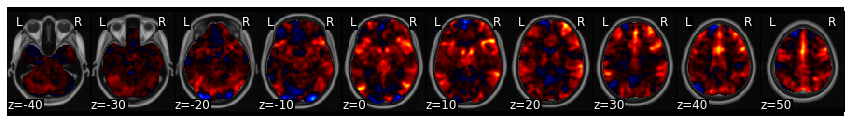

In [14]:
cond1_dat.mean().plot()

We can use the `ttest()` method to run a quick t-test across each voxel in the brain

In [16]:
cond1_stats = cond1_dat.ttest()

print(cond1_stats.keys())

dict_keys(['t', 'p'])


This returns a dictionary of a map of the t-values and a separate one containing the p-value for each voxel.

For now, let's look at the results of the t-test and threshold them to t >4

In [17]:
cond1_stats['t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

As you can see, there are very clear activation in dACC and insular, brain regions that typically activated by CS+ or pain.

However, if we want to test the hypothesis that there are specific areas of brain that process CS+, we could run a specific contrast comparing CS+ and CS-.

Now we need to load the CS- data and create a contrast between them.

Here a contrast is simply [1, -1] and can be archieved by simply substracting the two images (assuming that the subject are sorted in the same order).

In [19]:
cond2_name = 'CSmin'
cond2_file_list = glob.glob(os.path.join(data_dir, 'derivatives', 'fmriprep', '*', '*', 'func', f'sub*_ses*_{cond2_name}*nii.gz'))
cond2_file_list.sort()
cond2_dat = Brain_Data(cond2_file_list)

In [20]:
cond1_v_cond2 = cond1_dat - cond2_dat

Again, we will now run a one-sample ttest on the contrast to find regions that are consistently different in viewing CS+ vs. CS- across participants at the group level.

In [21]:
cond1_v_cond2_stats = cond1_v_cond2.ttest()
cond1_v_cond2_stats['t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Group statistics using design matrices

Most parametric statistical tests are just special cases of the general linear model.

### One Sample t-test

$$ y_{i} = \beta_{0} x_{i}$$

Or in matrix form:

$$ \begin{bmatrix}
s_{1} \\
s_{2} \\
s_{3} \\
s_{4} \\
s_{5} \\
s_{6} \\
\end{bmatrix} = \begin{bmatrix}
1 \\
1 \\
1 \\
1 \\
1 \\
1 \\
\end{bmatrix} 
\begin{bmatrix} \beta_{0} 
\end{bmatrix} $$

We can simulate this by generating data from a Gaussian distribution. We will general two group, where $y$ reflects equal draws from each of these distributions $group_{1} = \mathcal{N}(10, 2)$ and  $group_{2} = \mathcal{N}(5, 2)$. We then regress a vector of ones on $y$.

We report the estimated value of beta and compare it to various summariates of the simulated data. This allows us to see exactly  what each parameter in the regression is calculating.

First let's define a function `run_regression_simulation` to help us generate plots and calculate various ways to summarize the simulation.

In [11]:
def run_regression_simulation(x, y, paired=False):
    """ This function runs a regression and output results.
    """
    import numpy as np
    if not paired:
        b, t, p, df, res = regress(x, y)
        print(f"betas: {b}")
        
        if x.shape[1] > 1:
            print(f"beta1 + beta2: {b[0] + b[1]}")
            print(f"beta1 - beta2: {b[0] - b[1]}")
            print(f"mean(group1): {np.mean(group1)}")
            print(f"mean(group2): {np.mean(group2)}")
            print(f"mean(group1) - mean(group2): {np.mean(group1)-np.mean(group2)}")
        print(f"mean(y): {np.mean(y)}")
        
    else:
        beta, t, p, df, res = regress(x, y)
        a = y[x.iloc[:, 0]==1]
        b = y[x.iloc[:, 0]==-1]
        out = []
        
        for sub in range(1, X.shape[1]):
            sub_dat = y[X.iloc[:, sub]==1]
            out.append(sub_dat-np.mean(sub_dat))
        
        avg_sub_mean_diff = np.mean([x[0] for x in out])
                
        print(f"betas: {b}")
        print(f"contrast beta: {beta[0]}")
        print(f"mean(subject betas): {np.mean(beta[1:])}")

        print(f"mean(y): {np.mean(y)}")
        print(f"mean(a): {a.mean()}")
        print(f"mean(b): {b.mean()}")
        print(f"a - b: {np.mean(a)-np.mean(b)}")
        print(f"sum(a_i - mean(y_i))/n: {avg_sub_mean_diff}")
        
    
    # create plot
    f, a = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(pd.DataFrame(y), ax=a[0], cbar=False, yticklabels=False, xticklabels=False)
    sns.heatmap(x, ax=a[1], cbar=False, yticklabels=False)
    a[0].set_ylabel('Subject Values', fontsize=18)
    a[0].set_title('Y')
    a[1].set_title('X')
    plt.tight_layout()

Now, let's run the simulation for the one sample t-test

betas: 7.20598520224979
mean(y): 7.2059852022497894


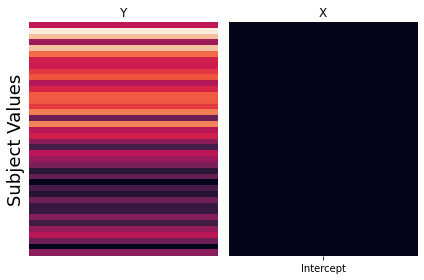

In [28]:
group1_params = {'n': 20, 'mean': 10, 'sd': 2}
group2_params = {'n': 20, 'mean': 5, 'sd':2}
group1=group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2=group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept': np.ones(len(y))})

run_regression_simulation(x, y, paired = False)

In [26]:
b, t, p, df, res = regress(x, y)
print(b)
print(t)
print(p)
print(df)
print(res)

7.752358897604097
17.640211145993785
0.0
39
[ 2.34639384  3.8995249   4.44060309  4.17086401  0.34421238  1.69632218
  4.14984119  1.63262017  0.76598155  3.31015283  5.79833287  2.61400036
  0.90519311  3.52819211 -1.1691353  -1.20381711  2.30706516  1.62825232
  0.34544062  2.8416205  -0.24710206 -1.94124137 -2.19663281 -1.23042141
 -1.16587193 -2.54629778 -3.89816798 -2.70597322 -1.3759324  -3.74249011
  0.82585261 -2.53988237 -2.59132706 -0.5163254  -4.87244547 -1.51186325
 -3.07434089 -4.33161725 -1.81991265 -2.86966801]


### Independent-Sample T-test - Dummy Codes

Next, let's explore how we can compute an indpendent sample t-test using a regression.

Design matrix


$$ \begin{bmatrix}
s_{1} \\
s_{2} \\
s_{3} \\
s_{4} \\
s_{5} \\
s_{6} \\
\end{bmatrix} = \begin{bmatrix}
1 & 1 \\
1 & 1 \\
1 & 1 \\
1 & 0 \\
1 & 0 \\
1 & 0 \\
\end{bmatrix} 
\begin{bmatrix} \beta_{0} \\ \beta_{1}
\end{bmatrix} $$


Let's run another simulation examining what the regression coefficients reflect using this dummy code approach.

betas: [4.76643704 4.8429743 ]
beta1 + beta2: 9.609411335079251
beta1 - beta2: -0.07653726254717075
mean(group1): 9.609411335079253
mean(group2): 4.766437036266042
mean(group1) - mean(group2): 4.8429742988132105
mean(y): 7.187924185672648


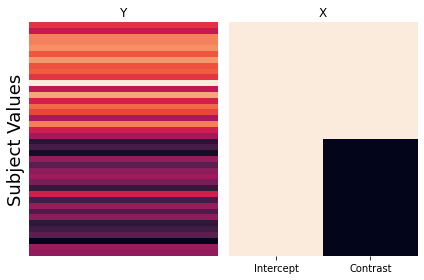

In [31]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}

group1=group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2=group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 
                  'Contrast':np.hstack([np.ones(group1_params['n']), np.zeros(group2_params['n'])])})

run_regression_simulation(x, y, paired = False)

The intercept $\beta_{0}$  is now the mean of the reference group, and the estimate of the dummy code regressor $\beta_{1}$ indicates the difference of the mean of the target group from the reference group.

Thus, the mean of the reference group is $\beta{0}$ or the intercept, and the mean of the target group is $\beta{1} + \beta_{0}$

### Independent-Sample T-test - Constrasts

Another way to compose two different groups is by creating a model with a intercept and contrast between the two groups.

Design matrix


$$ \begin{bmatrix}
s_{1} \\
s_{2} \\
s_{3} \\
s_{4} \\
s_{5} \\
s_{6} \\
\end{bmatrix} = \begin{bmatrix}
1 & 1 \\
1 & 1 \\
1 & 1 \\
1 & -1 \\
1 & -1 \\
1 & -1 \\
\end{bmatrix} 
\begin{bmatrix} \beta_{0} \\ \beta_{1}
\end{bmatrix} $$


Let's run another simulation examining what the regression coefficients reflect using this code approach.

betas: [7.7438967  2.27262038]
beta1 + beta2: 10.016517085551587
beta1 - beta2: 5.471276317620793
mean(group1): 10.016517085551587
mean(group2): 5.471276317620793
mean(group1) - mean(group2): 4.545240767930794
mean(y): 7.7438967015861895


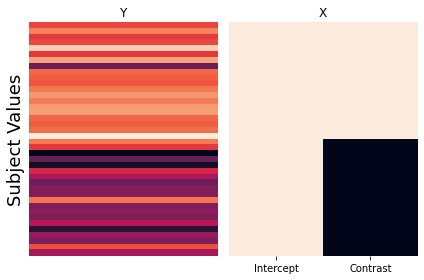

In [32]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}

group1=group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2=group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 
                  'Contrast':np.hstack([np.ones(group1_params['n']), -1*np.ones(group2_params['n'])])})

run_regression_simulation(x, y, paired = False)

Now, the $\beta_{0}$ reflects the mean of $y$, the $\beta_{1}$ is the average distance of each group to the mean. The mean of the group 1 is $\beta_{0} + \beta_{1}$, and the mean of group 2 is $\beta_{0} - \beta_{1}$.

Remember that in our earlier discussion of contrast codes, we noted the importance of balanced codes across regressors. What if the groups sizes are unbalanced? Will this affect our results?

To test this, we can double the sample size of group1 and rerun the simulation.

betas: [7.58794923 2.91644629]
beta1 + beta2: 10.504395514220924
beta1 - beta2: 4.671502942228245
mean(group1): 10.50439551422092
mean(group2): 4.671502942228241
mean(group1) - mean(group2): 5.83289257199268
mean(y): 8.560097990223362


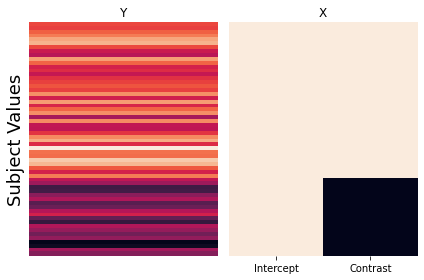

In [33]:
group1_params = {'n':40, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}

group1=group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2=group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 
                  'Contrast':np.hstack([np.ones(group1_params['n']), -1*np.ones(group2_params['n'])])})

run_regression_simulation(x, y, paired = False)

The beta estimates are similar to the previous simulation. This demonstrates that we do not need to adjust the weights of the number of ones and zeros to sum to zero. This is because the beta is estimating the avearage distance from the mean, which is invariant to group sizes.

### Independent-Sample T-test - Group Intercepts

The third way to calculate an independent sample t-test using a regression is to split the intercept into two separate binary regressors with each reflecting the membership of each group. There is no need to include an intercept as it is simply a linear combination of the other two regressors.

Design matrix


$$ \begin{bmatrix}
s_{1} \\
s_{2} \\
s_{3} \\
s_{4} \\
s_{5} \\
s_{6} \\
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
1 & 0 \\
1 & 0 \\
0 & 1 \\
0 & 1 \\
0 & 1 \\
\end{bmatrix} 
\begin{bmatrix} b_{0} \\ b_{1}
\end{bmatrix} $$


Let's run another simulation examining what the regression coefficients reflect using this dummy code approach.

betas: [9.70438474 4.81765355]
beta1 + beta2: 14.52203828919619
beta1 - beta2: 4.886731188723344
mean(group1): 9.704384738959769
mean(group2): 4.8176535502364235
mean(group1) - mean(group2): 4.8867311887233456
mean(y): 7.261019144598097


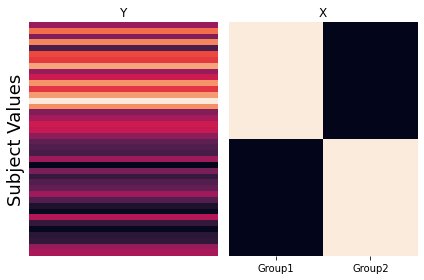

In [34]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}

group1=group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2=group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Group1':np.hstack([np.ones(len(group1)), np.zeros(len(group2))]), 
                  'Group2':np.hstack([np.zeros(len(group1)), np.ones(len(group2))])})

run_regression_simulation(x, y, paired = False)

This model separately estimating the means of each group, but how do we know if the difference is signficant?

Just like the single subject regression model, we'd need to do a calculation, which is $c = [1 -1]$.

All three of these diffrent appraoches will yield identical results when performing a hypothesis testing, but each is computing the t-test slightly differently.

## Paired-Sample T-Test

For paired-sample t-test, we nned to create a long format dataset in which each subject, $s_{i}$ has two data points (one for each condition, $a$ and $b$). One regressor will compute the contrast between condition $a$ and condition $b$. Just like before, we need to account for the mean, but instead of computing a grand mean for all the data, we will sepaarately model the mean of each participant by adding $n$ more binary regressors where each subject is indicated in each regressor. 


Design matrix


$$ \begin{bmatrix}
s_{1a} \\
s_{1b} \\
s_{2a} \\
s_{2b} \\
s_{3a} \\
s_{3b} \\
\end{bmatrix} = \begin{bmatrix}
1 & 1 & 0 & 0 \\
-1 & 1 & 0 & 0 \\
1 & 0 & 1 & 0 \\
-1 & 0 & 1 & 0 \\
1 & 0 & 0 & 1\\
-1 & 0 & 0 & 1 \\
\end{bmatrix} 
\begin{bmatrix} \beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \beta_{3}
\end{bmatrix} $$


The simulation will be slightly more complicated as we will be adding subject level noise to each data point. In this simulation, we will assume that $\epsilon_{i} = \mathcal{N}(30, 10)$

betas: [27.12074142 22.98574819 28.18639377 37.55286083 36.3578024  38.31102304
 17.1100367  28.08081613  6.64555671 46.2445587  55.52003773 29.63448225
 38.29217536 38.49661517 62.09652519 48.51109199 26.21224052 25.07092775
 33.23316544 49.46643341]
contrast beta: 2.69283474517902
mean(subject betas): 37.44929638063844
mean(y): 37.44929638063845
mean(a): 40.14213112581747
mean(b): 34.75646163545944
a - b: 5.385669490358033
sum(a_i - mean(y_i))/n: 2.6928347451790224


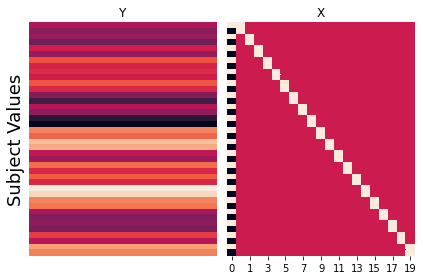

In [12]:
import numpy as np
import pandas as pd
a_params = {'mean':10, 'sd':2}
b_params = {'mean':5, 'sd':2}

sample_params = {'n':20, 'mean':30, 'sd':10}

y = []; x = []; sub_id = [];

for s in range(sample_params['n']):
    sub_mean = sample_params['mean'] + np.random.randn()*sample_params['sd']
    a = sub_mean + a_params['mean'] + np.random.randn()*a_params['sd']
    b = sub_mean + b_params['mean'] + np.random.randn()*b_params['sd']
    y.extend([a, b])
    x.extend([1, -1])
    sub_id.extend([s]*2)
    
y = np.array(y)

sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
sub_means = sub_means.replace({True:1, False:0})

X = pd.concat([pd.Series(x), sub_means], axis=1)

run_regression_simulation(X, y, paired=True)
    

Now, let's try to make sense all of these numbers.

First, there are $n+1$ $\beta$'s. $\beta_{0}$ corresponds to the between condition contrast. We will call this the *contrast* $\beta$. The rest of the $\beta$s model each subject's mean. We can see that the means of all of these subject's $\beta$'s corresponds to the overall mean of $y$.

Now what is the meaning of the contrast $\beta$?

We can see that it is not the average within subject differences between the two conditions as might be expected given a normal paired-sample t-test.

Instead, just like the indpendent samples t-test (**contrast coding**) descirbed above, the contrast value reflects the average deviation of a condition from each subject's individual mean.

$$\sum_{i = 1}^{n} \frac {a_{i} - mean(y_{i})}{n}$$

Where $n$ is the numer of subjects, $a$ is the condition being compared to $b$, and the $mean(y{i})$ is the subject's mean.

## Linear and Quadratic contrasts

Contrasts allow us to flexibly test many different types of hypothesis within the regression framework. This allows us to test more complicated and precise hypotheses than might be possible by simply tuning everything into a binary yes/no question (i.e., one sample t-test), or is condition $a$ greater than condition $b$ (i.e., two sample t-test). 

Here we will provide examples of how to test more sophisticated hypotheses.

Suppose that we manipulated the working memory load across four levels. we might be interested in identifying regions that monotomincally increase as a function of this manipulation. This would be virtually impossible to test using a paired contrast approach (e.g., t-tests, ANOVAs). Instead, we can simply sepecify a linear contrast by setting the contrast vector to linearly increase. This is as simple as [0, 1, 2, 3]. However, remember that contrasts need to sum to zero (except for the one-sample t-test). So to make our contrast we can simply substract the mean `np.array([0, 1, 2, 3]) - np.mean((np.array([0, 1, 2, 3]))`, which becomes $c_{linear} = [-1.5, -0.5, 0.5, 1.5]$

Regions invovled in working memory load might not have a linear increase, but instead might show an inverted u-shaped response, such that the region is not activated at small or high loads, but only at medium loads. To test this hypothesis, we would need to construct a quadratic contrast $c_{quadratic} = [-1, 1, 1, -1]$.

Let's explore with a simple simulation

Text(0.5, 1.0, 'Inverted U-response to WM laod')

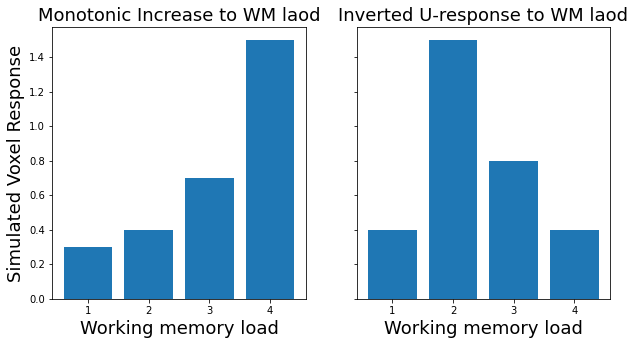

In [17]:
sim1 = np.array([.3, .4, .7, 1.5])
sim2 = np.array([.4, 1.5, .8,.4])

x = [1, 2, 3, 4]

# now let's plot our simulated data

f, a = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
a[0].bar(x, sim1)
a[1].bar(x, sim2)
a[0].set_ylabel('Simulated Voxel Response', fontsize=18)
a[0].set_xlabel('Working memory load', fontsize=18)
a[1].set_xlabel('Working memory load', fontsize=18)
a[0].set_title('Monotonic Increase to WM laod', fontsize=18)
a[1].set_title('Inverted U-response to WM laod', fontsize=18)

Now, let's create some contrasts and see how a linear or quadratic contrast might be able to detect these different predicted response.

Linear Contrast:[-1.5 -0.5  0.5  1.5]
Quadratic Contrast:[-1  1  1 -1]


Text(0.5, 1.0, 'Inverted U-response to WM laod')

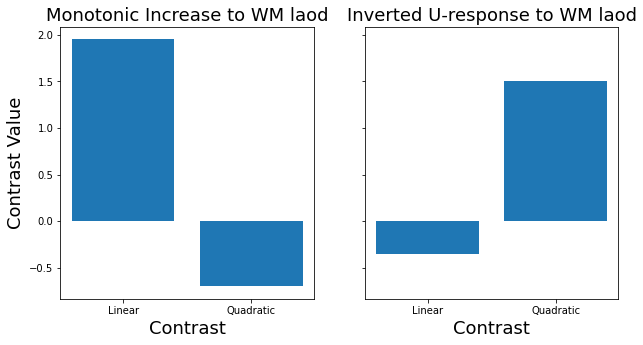

In [18]:
# First, create some contrast codes.
linear_contrast = np.array([-1.5, -0.5, .5, 1.5])
quadratic_contrast = np.array([-1, 1, 1, -1])

print(f'Linear Contrast:{linear_contrast}')
print(f'Quadratic Contrast:{quadratic_contrast}')

# Test our contrast on each dataset.

sim1_linear = np.dot(sim1, linear_contrast)
sim1_quad = np.dot(sim1, quadratic_contrast)
sim2_linear = np.dot(sim2, linear_contrast)
sim2_quad = np.dot(sim2, quadratic_contrast)

# Plot the contrast results
f, a = plt.subplots(ncols = 2, sharey=True, figsize=(10,5))
a[0].bar(['Linear', 'Quadratic'], [sim1_linear, sim1_quad])
a[1].bar(['Linear', 'Quadratic'], [sim2_linear, sim2_quad])
a[0].set_ylabel('Contrast Value', fontsize=18)
a[0].set_xlabel('Contrast', fontsize=18)
a[1].set_xlabel('Contrast', fontsize=18)
a[0].set_title('Monotonic Increase to WM laod', fontsize=18)
a[1].set_title('Inverted U-response to WM laod', fontsize=18)

Here is shows that the linear contrast is sensitive to detect responses that monotoinically increase, while the quadratic contrast is more sensitive to responses that show an inverted u-response.

If we were to apply this to real brain data, we could now find regions that show a linear or quadratic responses to an experimental manipulation across the whole brain. Then, we test the null hypothesis that there is no group effect of a linear or quadratic contrast at the second level.